<a href="https://colab.research.google.com/github/ldk7024/Deep_Learning_Study/blob/main/21_07_28_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A6%9D%EC%8B%9D%2C_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5_%ED%99%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 데이터 증식, 전이학습을 이용하여 공유, 김고은 이미지 분류

### 1.학습용 이미지에 대한 증식없이 학습시키기
### 2.증식하여 학습시키기

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters
from tensorflow.keras.applications import InceptionResNetV2     # 성능이 높은 이미지 처리 전이학습모델
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator    # 이미지 증식을 위한 라이브러리

- 전이학습 모델 불러오기 (InceptionResNetV2 )

In [51]:
InceptionResNetV2 = InceptionResNetV2(include_top=False,
                                      weights = 'imagenet',
                                      input_shape=(224,224,3)
                                      )

In [52]:
InceptionResNetV2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_812 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_812 (BatchN (None, 111, 111, 32) 96          conv2d_812[0][0]                 
__________________________________________________________________________________________________
activation_812 (Activation)     (None, 111, 111, 32) 0           batch_normalization_812[0][0]    
________________________________________________________________________________

In [53]:
for layer in InceptionResNetV2.layers :
  layer.trainable = False
print(InceptionResNetV2.summary())

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_812 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_812 (BatchN (None, 111, 111, 32) 96          conv2d_812[0][0]                 
__________________________________________________________________________________________________
activation_812 (Activation)     (None, 111, 111, 32) 0           batch_normalization_812[0][0]    
________________________________________________________________________________

### 학습용 이미지에 대한 증식 없이 학습시키기

In [54]:
# ImageDataGenarator: 이미지를 생성하기 위한 함수
# 따로 조건 없이 픽셀값들의 범위만 조정해주기
# 이미지를 생성하기 위한 조건 설정

train_datagen1 = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 30,              # 이미지의 회전각도 설정
                                    width_shift_range = 0.2,          # 20% 내외 수평이동
                                    height_shift_range = 0.2,         # 20% 내외 수직이동
                                    shear_range = 0.2,                # 0.2 라디안 내외 시계반대방향 변형
                                    zoom_range = 0.2,                 # 0.8~1.2배로 축소/확대
                                    horizontal_flip = True,           # 수평방향으로 뒤집기
                                    fill_mode = 'nearest')            # 이미지가 변형되면서 비는 공간으로 자동으로 채워주기
val_datagen1 = ImageDataGenerator(rescale=1./255) # 0~255 픽셀값을 0~1로 조정

train_dir = '/content/drive/MyDrive/Colab Notebooks/빅데이터4차(딥러닝)/data/imgdd/img/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/빅데이터4차(딥러닝)/data/imgdd/img/val'

# flow_from_directory : 실제로 이미지를 생성하여 학습시 공급
train_generator1 = train_datagen1.flow_from_directory(train_dir,
                                                      batch_size = 20,
                                                      # 생성되는 이미지의 크기
                                                      target_size = (224,224),
                                                      # 랜덤하게 생성
                                                      shuffle = True,
                                                      # 정담을 자동으로 만들어서 학습시 넣어줌 (binary, categorical)
                                                      class_mode = 'binary')
val_generator = val_datagen1.flow_from_directory(val_dir,
                                                      batch_size = 10,
                                                      # 생성되는 이미지의 크기
                                                      target_size = (224,224),
                                                      # 랜덤하게 생성
                                                      shuffle = True,
                                                      # 정담을 자동으로 만들어서 학습시 넣어줌 (binary, categorical)
                                                      class_mode = 'binary')

Found 200 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


### 신경망 설계

In [55]:
gen_model = Sequential()

gen_model.add(InceptionResNetV2)

gen_model.add(Flatten())
gen_model.add(Dense(5000, activation='relu'))
gen_model.add(Dense(1000, activation='relu'))
gen_model.add(Dense(100, activation='relu'))

gen_model.add(Dense(1, activation='sigmoid'))

gen_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 5000)              192005000 
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              5001000   
_________________________________________________________________
dense_10 (Dense)             (None, 100)               100100    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 251,442,937
Trainable params: 197,106,201
Non-trainable params: 54,336,736
_______________________________

In [56]:
gen_model.compile(loss='binary_crossentropy',
                  optimizer = Adam(lr=0.0001),
                  metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [57]:
h = gen_model.fit_generator(train_generator1, # train 데이터 생성기 자체를 넣어줌
                        steps_per_epoch=10, # 한 epoch 당 10번 돌고 끝나게 됨 (20*10으로 총 200개의 이미지를 생성)
                        validation_data = val_generator, 
                        validation_steps = 4,
                        epochs = 30
                        )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
10/10 [==============================] - 14s 573ms/step - loss: 1.6295 - acc: 0.5700 - val_loss: 0.2357 - val_acc: 0.9500
Epoch 2/30
10/10 [==============================] - 3s 309ms/step - loss: 0.3906 - acc: 0.8250 - val_loss: 0.2432 - val_acc: 0.9000
Epoch 3/30
10/10 [==============================] - 3s 300ms/step - loss: 0.4069 - acc: 0.8400 - val_loss: 0.1253 - val_acc: 0.9250
Epoch 4/30
10/10 [==============================] - 3s 304ms/step - loss: 0.1821 - acc: 0.9200 - val_loss: 0.1347 - val_acc: 0.9250
Epoch 5/30
10/10 [==============================] - 3s 305ms/step - loss: 0.2227 - acc: 0.9250 - val_loss: 0.1754 - val_acc: 0.9250
Epoch 6/30
10/10 [==============================] - 3s 305ms/step - loss: 0.1374 - acc: 0.9500 - val_loss: 0.0938 - val_acc: 0.9750
Epoch 7/30
10/10 [==============================] - 3s 303ms/step - loss: 0.1022 - acc: 0.9800 - val_loss: 0.0877 - val_acc: 0.9750
Epoch 8/30
10/10 [==============================] - 3s 308ms/step - loss: 0

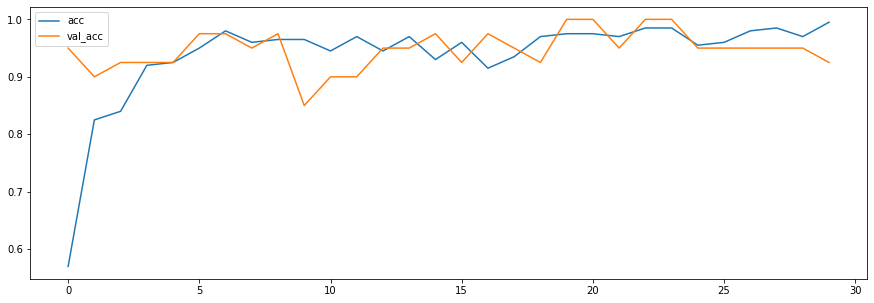

In [58]:
plt.figure(figsize=(15,5))

plt.plot(h.history['acc'],
         label = 'acc')

plt.plot(h.history['val_acc'],
         label = 'val_acc')

plt.legend()
plt.show()